<a href="https://colab.research.google.com/github/dsweet99/notebooks/blob/main/(subtle)_Variations_on_a_prompt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (subtle) Variations on a prompt

Stable diffusion + novelty search

## Problem

Creating variations for given prompt by randomly changing the latent-space noise (or, equivalently, changing a seed), produces wildly different final images.  This is appropriate for initial exploration, but once you find an image you like, it would be nice to generate smaller variations.

Let's say you have chosen an image that you like. Call it the root image. First, place it in a new list called `archive`.

The function `vary_image()`, below, searches for images that are
1. Different enough from images in `archive`, 
2. Similar enough to the initial, root image.

Then it adds the image it finds to `archive`.

Calling `vary_image()` repeatedly causes the archive to grow, filling with images that are all different from each other but not "too different" from the root image.

## References

[K. Stanley, Abandoning Objectives: Evolution through the Search for Novelty Alone](https://www.cs.swarthmore.edu/~meeden/DevelopmentalRobotics/lehman_ecj11.pdf)

This notebook was derived from [Best Avaliable Stable Diffusion™](https://colab.research.google.com/drive/174iLnLZbO4yKTwKHw1L4ljQTnKez4K7l#scrollTo=NtCNhPr_2qm3)

[Tweet about pumpkins](https://twitter.com/phinance99/status/1583934760329523201?s=20&t=V2oyyfmX_iur4vNEiDpPcw)

[Tweet about masks](https://twitter.com/phinance99/status/1583955380089913344?s=20&t=V2oyyfmX_iur4vNEiDpPcw)


In [3]:
#@title Install Stuff
!pip --quiet install diffusers transformers ftfy huggingface_hub
!pip --quiet  install image-similarity-measures
from PIL import Image
import numpy as np
from IPython.display import clear_output
from image_similarity_measures.quality_metrics import rmse, psnr, ssim

In [4]:
#@title Login to the Hugging Face Hub
#@markdown Don't forget to visit [the repo page](https://huggingface.co/runwayml/stable-diffusion-v1-5), read and accept the LICENSE if you agree
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [5]:
#@title Set up the pipeline
from diffusers.models import AutoencoderKL
from diffusers import StableDiffusionPipeline
from torch import autocast
import torch

model = "runwayml/stable-diffusion-v1-5" #@param {type:"string"}
vae = "sd-vae-ft-mse" #@param["original", "sd-vae-ft-mse", "sd-vae-ft-ema"]
if(vae!="original"):
  vae = AutoencoderKL.from_pretrained(f"stabilityai/{vae}")
  pipe = StableDiffusionPipeline.from_pretrained(model, vae=vae, torch_dtype=torch.float16, revision="fp16")
else:
  pipe = StableDiffusionPipeline.from_pretrained(model, torch_dtype=torch.float16, revision="fp16") 
pipe.to("cuda")
clear_output()
print ("Ok")

Ok


In [6]:
#@title Helper functions

def image_grid(imgs, resize=(128,128), num_cols=5):
    cols = min(num_cols, len(imgs))
    rows = 1 + (len(imgs)-1)//num_cols

    if resize:
      imgs = [img.resize(resize) for img in imgs]

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

def gen_image(prompt, latents):
  num_samples = 1
  steps = 50
  guidance_scale = 7.5
  with autocast("cuda"):
      return pipe(
          [prompt] * num_samples, 
          num_inference_steps=steps, 
          guidance_scale=guidance_scale, 
          latents=latents,
          ).images[0]


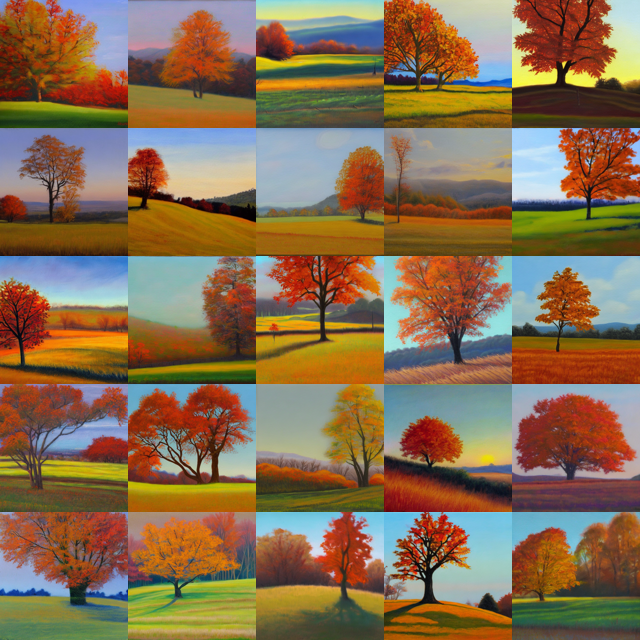

In [42]:
#@title Choose a root image

# Experiment with prompt to find a starting image.

# prompt = "a pumpkin on a small table, studio photography"
# prompt = "display photograph of a cute high-quality halloween monster mask"
prompt = "autumn, dawn, view from a distance; a single maple tree alone on a grassy hill painting"

candidates = []
for seed in range(25):
  torch.manual_seed(seed)
  latents_0 = torch.randn(size=(1,4,64,64))
  image_0 = gen_image(prompt, latents_0)
  candidates.append( (image_0, latents_0) )
  clear_output(wait=True)
  display(image_grid([img for img,_ in candidates], resize=(128,128)))

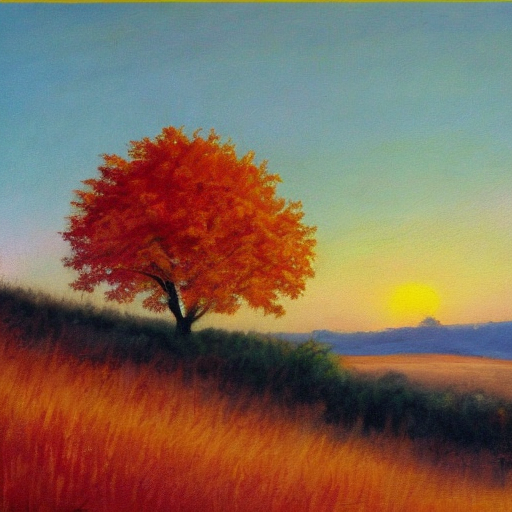

In [43]:
# Choose your root image by setting `i_favorite`.
# Initialize the archive with the root image.

# i_root = 20   # pumpkins
# i_root = 24  # masks
i_root = 18

archive = [ candidates[i_root] ]
display(candidates[i_root][0].resize( (512,512) ))

# Fill the archive

In [44]:
def dist_to_archive(archive, image, fn):
  return np.array([
      fn(img, image)
      for img, _ in archive
  ])

def distance(img_0, img_1):
  # What would be a good distance / similarity metric?
  # There's no special reason to use `ssim() here.
  return 1 - ssim(np.array(img_0), np.array(img_1))

In [45]:
def vary_image(prompt, archive, min_dist_to_archive, max_dist_to_original,
               num_cols=4, add_to_archive=True, verbose=False):

  def header():
    clear_output(wait=True)
    display(image_grid([img for img,_ in archive], num_cols=num_cols))

  header()

  eps = 0.1
  eps_min, eps_max = .003, .3
  _, latents_0 = archive[0] # archive[np.random.randint(len(archive))]
  latents = latents_0.clone()
  max_dist = 0
  tried = []
  for _ in range(100):
    if verbose:
      print (f"eps = {eps:.4f}")
    d_latents = eps*torch.randn(size=(1,4,64,64))
    image = gen_image(prompt, latents + d_latents)
    tried.append(image)

    dist = dist_to_archive(archive, image, distance)
    dist = dist.min()

    dist_to_original = distance(archive[0][0], image)
    
  
    if verbose:
      print (f"dist = {dist:.4f}")
      print()
    else:
      header()
    display(image_grid(tried, resize=(64,64), num_cols=10))
    print (f"dist_to_archive = {dist:.4f} dist_to_original = {dist_to_original:.4f}")

    if dist_to_original > max_dist_to_original:
      eps = max(eps_min, eps/1.3)
      print (f"too far from original {dist_to_original:.4f} > {max_dist_to_original:.4f}")
      continue

    if dist > max_dist:
      print (f"getting better {dist:.4f} > {max_dist:.4f}")
      latents += d_latents
      max_dist = dist
    else:
      eps = min(eps_max, 1.3*eps)

    if dist > min_dist_to_archive:
      if not verbose:
        header()
      else:
        print (f"found new variation, distance = {dist:.4f}")

      if add_to_archive:
        archive.append( (image, latents) )
      return image
  

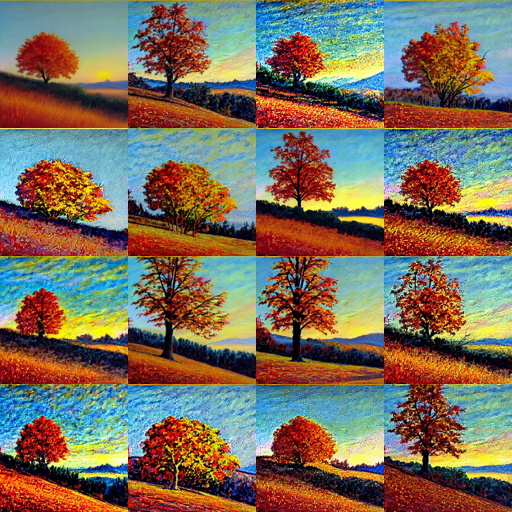

In [47]:
while len(archive) < 16:
  vary_image(
    prompt, archive,
    # min_dist_to_archive: How different does an image have to be to 
    #  make it into the archive?
    min_dist_to_archive=.085, 
    # max_dist_to_original: How similary does an image have to be to the root
    #  to quality for the archive?
    max_dist_to_original=.15,
    num_cols=4,
  )
clear_output(wait=True)
display(image_grid([img for img,_ in archive], num_cols=4))

# happy little trees

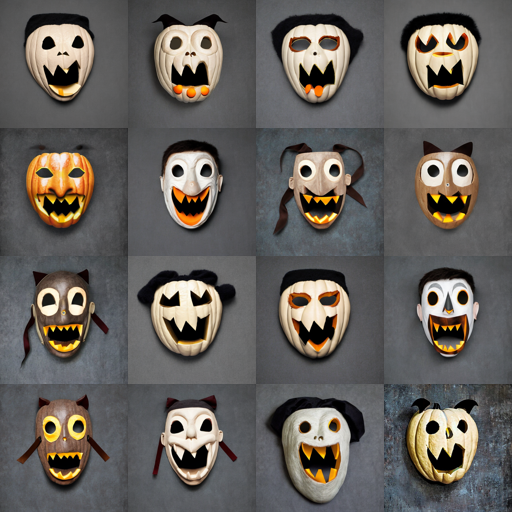

In [ ]:
# prompt = "display photograph of a cute high-quality halloween monster mask"
# i_root = 24
# min_dist_to_archive=.05, 
# max_dist_to_original=.10,

# display(image_grid([img for img,_ in archive], num_cols=4))

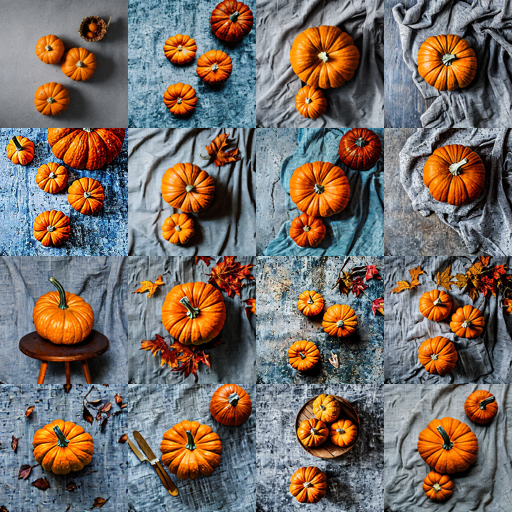

In [ ]:
# prompt = "a pumpkin on a small table, studio photography"
# i_root = 20
# min_dist_to_archive=.15
# max_dist_to_original=.25

# display(image_grid([img for img,_ in archive], num_cols=4))